In [1]:
!pip install kaggle

Loading the Datset with real images from Flickr and fake images generated by StyleGAN

In [2]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [01:44<00:00, 41.5MB/s]
100% 3.75G/3.75G [01:44<00:00, 38.6MB/s]


In [3]:
# Unzip the downloaded dataset
!unzip 140k-real-and-fake-faces.zip -d dataset


Streaming output truncated to the last 5000 lines.
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: dataset/real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: dataset/real_vs_fake/real-

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [5]:
real_face_dataset = '/content/dataset/real_vs_fake/real-vs-fake/train/real'

In [6]:
def show_samples(image_folder, num_samples=5):
    # Get a list of all images in the specified folder
    all_images = os.listdir(image_folder)

    # Randomly select a few images to display
    selected_images = random.sample(all_images, num_samples)

    # Plot the selected images
    plt.figure(figsize=(15, 6))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(image_folder, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, num_samples, i + 1)  # Create a subplot for each image
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.title(img_name)  # Show the image name as title

    plt.tight_layout()
    plt.show()

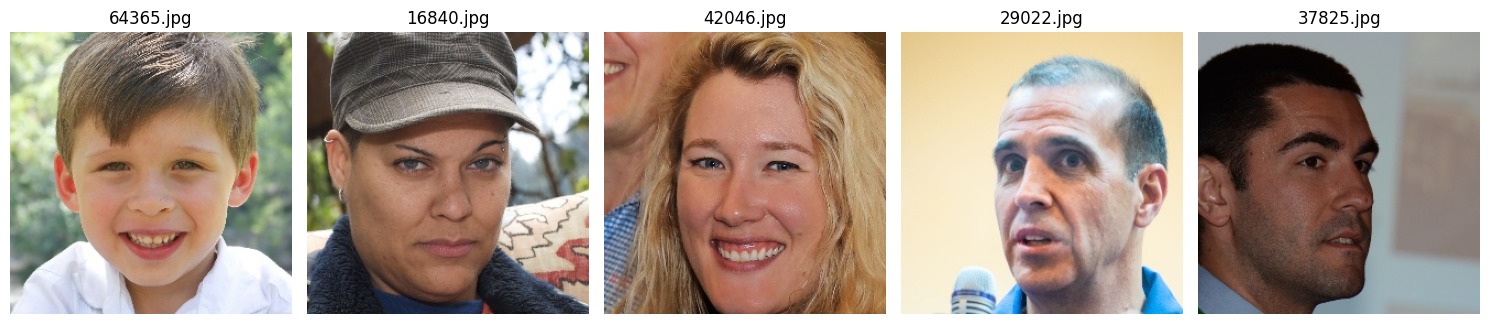

In [7]:
show_samples(real_face_dataset, num_samples=5)

In [8]:
import shutil
from sklearn.model_selection import train_test_split

In [9]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [10]:
dataset_path = '/content/dataset/real_vs_fake/real-vs-fake/train/fake'


In [11]:
def display_images(num_images=5):
    images = []
    image_files = os.listdir(dataset_path)

    # Load the specified number of images
    for i in range(min(num_images, len(image_files))):
        img_path = os.path.join(dataset_path, image_files[i])
        img = Image.open(img_path).convert("RGB")  # Open image and convert to RGB
        images.append(img)

    # Display the images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

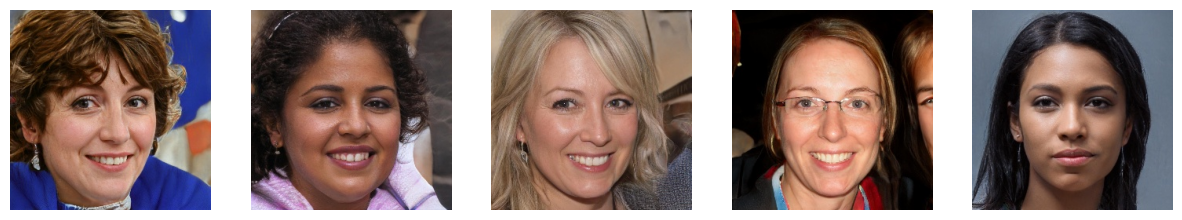

In [12]:
display_images(num_images=5)

In [13]:
!rm -rf /content/real_face_dataset/train/.ipynb_checkpoints
!rm -rf /content/synthetic_faces_dataset/train/.ipynb_checkpoints


In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations (normalization, augmentation)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize based on ImageNet mean and std
])

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, directory, label, max_images=None):
        self.directory = directory
        self.label = label
        self.image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if is_valid_image_file(fname)]

        # Limit the number of images if max_images is specified
        if max_images is not None and len(self.image_paths) > max_images:
            self.image_paths = random.sample(self.image_paths, max_images)  # Randomly sample max_images paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = data_transforms(image)
        return image, self.label

def is_valid_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

# Paths to training datasets
real_face_train_dir = '/content/dataset/real_vs_fake/real-vs-fake/train/real'
synthetic_face_train_dir = '/content/dataset/real_vs_fake/real-vs-fake/train/fake'

# Set the maximum number of images to 5000 for each dataset
max_images = 20000

# Create datasets for real and synthetic faces, limiting to 5000 images each
real_dataset = CustomImageDataset(real_face_train_dir, label=0, max_images=max_images)  # Label 0 for real faces
synthetic_dataset = CustomImageDataset(synthetic_face_train_dir, label=1, max_images=max_images)  # Label 1 for synthetic faces

# Combine both datasets
train_dataset = torch.utils.data.ConcatDataset([real_dataset, synthetic_dataset])

# DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pre-trained DenseNet121
model = models.densenet121(pretrained=False)

# Modify the classifier part of the DenseNet to fit binary classification
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 1),
    nn.Sigmoid()  # Output layer for binary classification (real vs synthetic)
)

# Move model to the device (GPU or CPU)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0
    tp, fp, fn = 0, 0, 0  # Initialize true positives, false positives, and false negatives

    for inputs, labels in train_loader:
        # Move inputs and labels to device (GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float and reshape for BCE Loss

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        preds = (outputs > 0.5).float()  # Convert sigmoid output to binary (0 or 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Update TP, FP, FN for precision and recall
        tp += torch.sum((preds == 1) & (labels == 1)).item()
        fp += torch.sum((preds == 1) & (labels == 0)).item()
        fn += torch.sum((preds == 0) & (labels == 1)).item()

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'densenet_face_classification.pth')

print("Model training completed and saved!")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/9, Loss: 0.6719, Accuracy: 0.5924, Precision: 0.5917, Recall: 0.5958
Epoch 1/9, Loss: 0.6096, Accuracy: 0.6703, Precision: 0.6734, Recall: 0.6612
Epoch 2/9, Loss: 0.5356, Accuracy: 0.7365, Precision: 0.7441, Recall: 0.7209
Epoch 3/9, Loss: 0.4549, Accuracy: 0.7908, Precision: 0.7957, Recall: 0.7824
Epoch 4/9, Loss: 0.3939, Accuracy: 0.8276, Precision: 0.8307, Recall: 0.8228
Epoch 5/9, Loss: 0.3474, Accuracy: 0.8508, Precision: 0.8523, Recall: 0.8488
Epoch 6/9, Loss: 0.3019, Accuracy: 0.8719, Precision: 0.8743, Recall: 0.8686
Epoch 7/9, Loss: 0.2684, Accuracy: 0.8903, Precision: 0.8931, Recall: 0.8867
Epoch 8/9, Loss: 0.2382, Accuracy: 0.9035, Precision: 0.9079, Recall: 0.8980
Epoch 9/9, Loss: 0.2086, Accuracy: 0.9152, Precision: 0.9155, Recall: 0.9149
Model training completed and saved!


<ipython-input-15-5306648a1a06>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('densenet_face_classification.pth'))


Test Accuracy: 91.22%


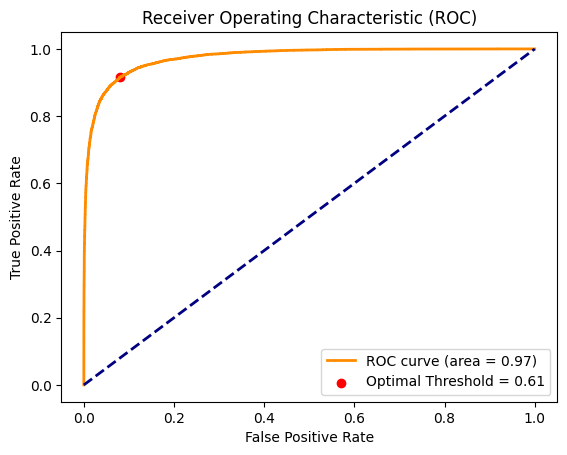

Optimal Threshold: 0.61
AUC: 0.97


In [15]:
import os
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformations (same as training)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images to 224x224
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize based on ImageNet mean and std
])

# Custom dataset class for test data
class CustomImageDataset(Dataset):
    def __init__(self, directory, label):
        self.directory = directory
        self.label = label
        self.image_paths = [os.path.join(directory, fname) for fname in os.listdir(directory) if is_valid_image_file(fname)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        image = data_transforms(image)
        return image, self.label

def is_valid_image_file(filename):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp']
    return any(filename.lower().endswith(ext) for ext in valid_extensions)

# Paths to test datasets
real_face_test_dir = '/content/dataset/real_vs_fake/real-vs-fake/test/real'
synthetic_face_test_dir = '/content/dataset/real_vs_fake/real-vs-fake/test/fake'

# Create datasets for test data
real_test_dataset = CustomImageDataset(real_face_test_dir, label=0)  # Label 0 for real faces
synthetic_test_dataset = CustomImageDataset(synthetic_face_test_dir, label=1)  # Label 1 for synthetic faces

# Combine both test datasets
test_dataset = torch.utils.data.ConcatDataset([real_test_dataset, synthetic_test_dataset])

# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the trained model
model = models.densenet121(pretrained=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load('densenet_face_classification.pth'))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Evaluate the model and collect outputs
all_labels = []
all_preds = []
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert labels to float and reshape for BCE Loss

        # Forward pass
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        preds = (outputs > 0.5).float()  # Convert sigmoid output to binary (0 or 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

# Calculate accuracy
accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.2f}%')

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Determine the optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f'Optimal Threshold: {optimal_threshold:.2f}')
print(f'AUC: {roc_auc:.2f}')
